# En este notebook se hace un análisis avanzado del regresor kNN con la representación vectorial TF-IDF

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

import os
from termcolor import colored
import tqdm
import scipy
import gc
import joblib

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab

pylab.rcParams['figure.figsize'] = 9, 6

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Cargar los datos desde el archivo JSON
#data_path = '/content/drive/My Drive/proyecto/full_format_recipes.json'  # Clara
data_path = '/content/drive/My Drive/Colab Notebooks/proyecto/full_format_recipes.json'  # Jorge
recipes_df = pd.read_json(data_path)

import scipy.sparse
# Cargamos la matriz TF-IDF
#matriz_tfidf = scipy.sparse.load_npz('/content/drive/My Drive/proyecto/TFIDF.npz')#clara
matriz_tfidf = scipy.sparse.load_npz('/content/drive/My Drive/Colab Notebooks/proyecto/TFIDF.npz')#jorge

# Cargar el vectorizador TF-IDF
tfidf = joblib.load('/content/drive/My Drive/Colab Notebooks/proyecto/tfidf_vectorizer.joblib')

Mounted at /content/drive


### **1. Preparación de los datos de entrenamiento y de test**

In [ ]:
from re import X
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

target = recipes_df['rating']
print(min(target)) #0
print(max(target)) #5
#target = target.fillna(target.mean()) # Relleno los valores que faltan (NaN) con media
# Convertimos el target en variable categórica (valores 0 o 1)
# Dividimos los datos en conjunto de entrenamiento y de test, features (X) y labels (y)
X_train, X_test, y_train, y_test = train_test_split(matriz_tfidf, target, test_size=0.2, random_state=42)

# Normalizamos los datos para que tengan media cero y varianza unidad de forma
# que mejore el funcionamiento del algoritmo
scaler = StandardScaler(with_mean=False)
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Rellenar los valores NaN con la media de las etiquetas
y_train = y_train.fillna(y_train.mean())
y_test = y_test.fillna(y_test.mean())

0.0
5.0


### **2. Entrenamiento y evaluación**

#### ***2.1 Modelo de regresión con técnica de librería Scikit Learn***

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Mejor valor de k: 49


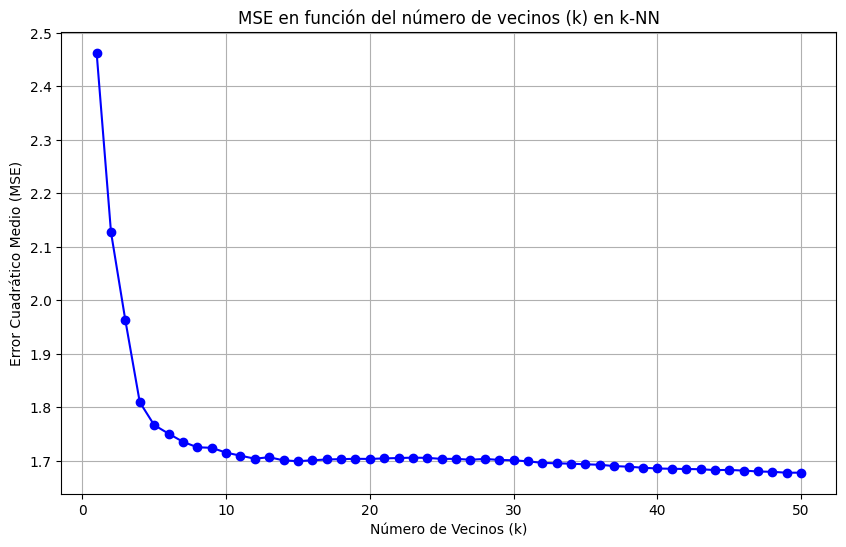

Mean Squared Error con el mejor k (49): 1.6962959149384018
R-squared con el mejor k (49): 0.05998457911485089


In [ ]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Seleccionamos las mejores características (1000 características)
# Es recomendable normalizar las características antes de entrenar un modelo k-NN, ya que la métrica
# de distancia utilizada por k-NN se ve afectada por las escalas de las variables.

k_best = SelectKBest(f_regression, k=1000)  # Seleccionamos las 1000 mejores características, con 10000 veíamos un peor MSE overfitting
#tiene sentido ya que estamso sobreajustando demasiado y hay muchas características que estan muy correladas con otras

X_train_selected = k_best.fit_transform(X_train, y_train)
X_test_selected = k_best.transform(X_test)

# Definimos el rango de valores de k a probar
k_values = range(1, 51)  #un valor muy grande puede llevar a undefitting

# Creamos el modelo de k-NN
knn = KNeighborsRegressor()

# Definir los parámetros a buscar
param_grid = {'n_neighbors': k_values}

# Usar GridSearchCV para encontrar el mejor valor de k
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train_selected, y_train)

# Imprimir el mejor valor de k
print(f"Mejor valor de k: {grid_search.best_params_['n_neighbors']}")

# Obtener los resultados de la búsqueda para visualizar
results = grid_search.cv_results_

# Graficar la MSE para cada valor de k
plt.figure(figsize=(10, 6))
plt.plot(k_values, -results['mean_test_score'], marker='o', color='b', label="MSE")
plt.xlabel('Número de Vecinos (k)')
plt.ylabel('Error Cuadrático Medio (MSE)')
plt.title('MSE en función del número de vecinos (k) en k-NN')
plt.grid(True)
plt.show()

# Entrenar el modelo k-NN con el mejor valor de k
best_k = grid_search.best_params_['n_neighbors']
model = KNeighborsRegressor(n_neighbors=best_k)
model.fit(X_train_selected, y_train)

# Predicciones y evaluación
y_pred = model.predict(X_test_selected)

# Evaluar rendimiento
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error con el mejor k ({best_k}):", mse)
print(f"R-squared con el mejor k ({best_k}):", r2)

In [ ]:
#nos quedamos con k=20 ya que ya es un valor bastante bueno de MSE , valores más grandes de k nos dan mejores resultados,
#pero también se considera que un k demasiado alto podría llevar a underfitting (es decir, el modelo se vuelve demasiado simple y no
#captura la complejidad de los datos).

Resultados con k = 20:
Mean Squared Error con k=20: 1.7077129943126528
R-squared con k=20: 0.053657716815205814


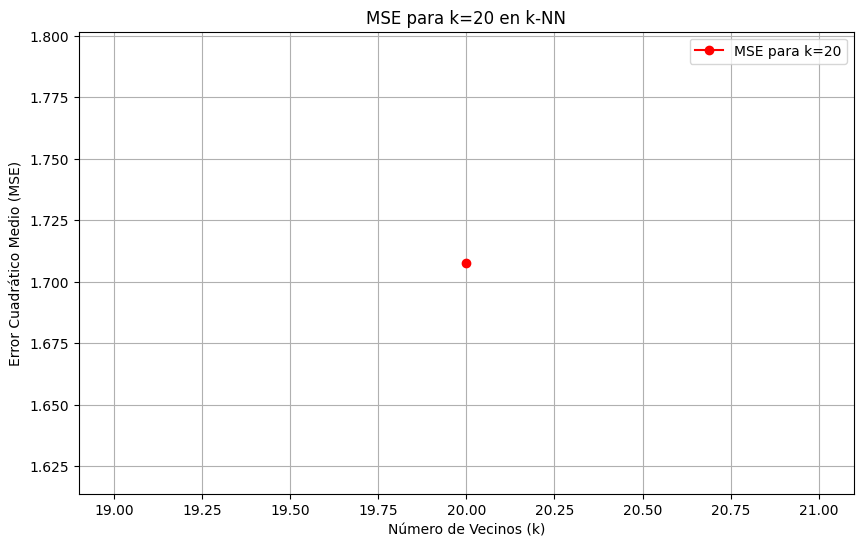

In [ ]:
# Definimos el valor de k que queremos evaluar (k=20)
k_value = 20

# Creamos el modelo de k-NN con k=20
knn = KNeighborsRegressor(n_neighbors=k_value)

# Entrenamos el modelo con los datos seleccionados
knn.fit(X_train_selected, y_train)

# Predicciones y evaluación
y_pred = knn.predict(X_test_selected)

# Evaluar rendimiento
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Resultados con k = {k_value}:")
print(f"Mean Squared Error con k={k_value}:", mse)
print(f"R-squared con k={k_value}:", r2)

# Si deseas graficar el MSE para k=20
plt.figure(figsize=(10, 6))
plt.plot([k_value], [mse], marker='o', color='r', label="MSE para k=20")
plt.xlabel('Número de Vecinos (k)')
plt.ylabel('Error Cuadrático Medio (MSE)')
plt.title('MSE para k=20 en k-NN')
plt.grid(True)
plt.legend()
plt.show()

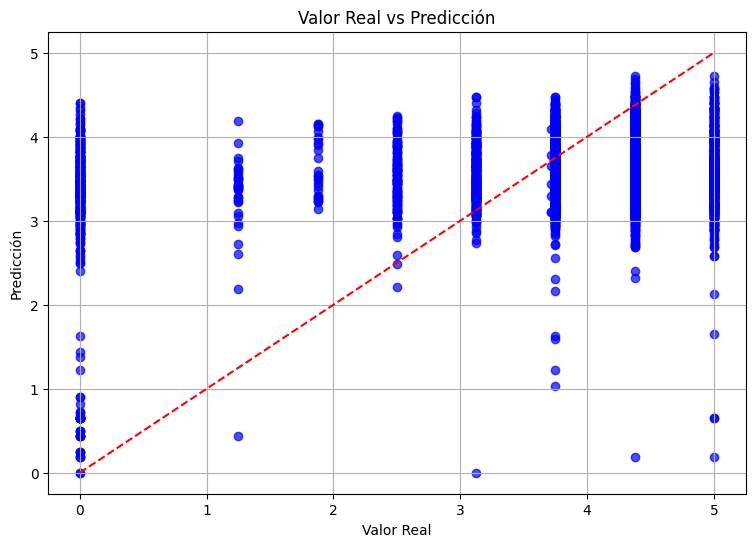

In [ ]:
#visualización de las predicciones:
plt.scatter(y_test, y_pred, alpha=0.7, color='b')
plt.plot([0, 5], [0, 5], color='r', linestyle='--')  # Línea de referencia
plt.xlabel('Valor Real')
plt.ylabel('Predicción')
plt.title('Valor Real vs Predicción')
plt.grid(True)
plt.show()

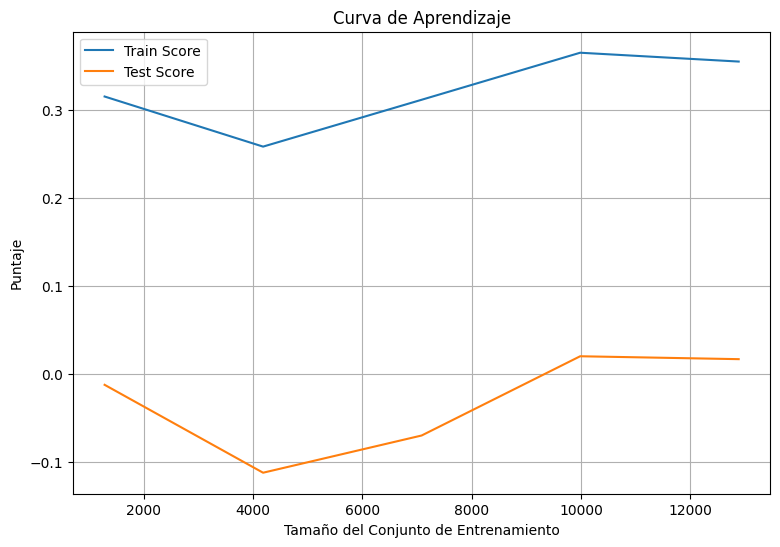

In [ ]:
#curva de aprendizaje
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(knn, X_train_selected, y_train, cv=5)

plt.plot(train_sizes, np.mean(train_scores, axis=1), label="Train Score")
plt.plot(train_sizes, np.mean(test_scores, axis=1), label="Test Score")
plt.xlabel('Tamaño del Conjunto de Entrenamiento')
plt.ylabel('Puntaje')
plt.title('Curva de Aprendizaje')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#tanto el puntaje de entrenamiento como el de prueba son bajos, es posible que el modelo esté subajustado.

#test score:El puntaje de prueba es bajo en todo el rango de tamaños de datos, lo cual es un indicio claro
#de que el modelo no está aprendiendo de manera eficiente con los datos disponibles.

#TF-IDF puede generar una gran cantidad de características (palabras), muchas de las cuales pueden no ser relevantes
#para el modelo. Si no se realiza una selección de características adecuada (como la que estás haciendo con SelectKBest)

analisis características más relevantes con TF-IDF

<ipython-input-16-051ccaeceb2e>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_scores, y=top_features, palette='viridis')


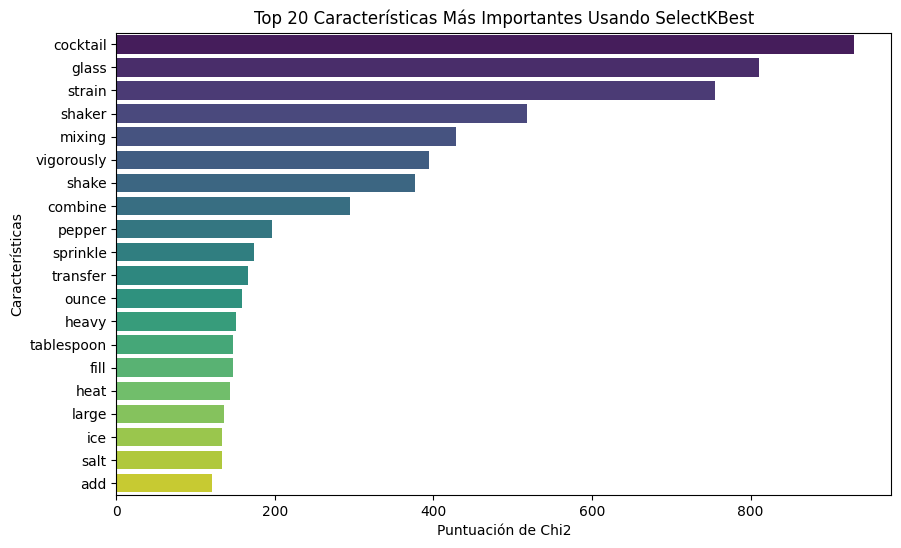

In [ ]:
#como las palabras más relevantes influyen modelo.
# Obtener los nombres de las características correspondientes

feature_names = tfidf.get_feature_names_out()

# 1. Obtener los índices de las mejores características
top_indices = np.argsort(k_best.scores_)[::-1]  # Ordenar por puntuación de mayor a menor

# 2. Obtener los nombres de las características correspondientes

feature_names = tfidf.get_feature_names_out()

# 3. Obtener las 20 características más importantes
top_n = 20
top_features = [feature_names[i] for i in top_indices[:top_n]]
top_scores = k_best.scores_[top_indices[:top_n]]

# 4. Crear un gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=top_scores, y=top_features, palette='viridis')
plt.title(f'Top {top_n} Características Más Importantes Usando SelectKBest')
plt.xlabel('Puntuación de f-regression')
plt.ylabel('Características')
plt.show()